# **Analysis of the Rome housing market**

In [1]:
%matplotlib inline

import re
from copy import copy

import numpy as np
import pandas as pd
from scipy.stats import norm

from matplotlib import pyplot as plt
from PIL import Image
import seaborn as sns

sns.set(style='whitegrid')
pd.options.display.float_format = '{:,.2f}'.format

# Data cleaning and single variable exploration

## Error rates

Of course no scraper is perfect, and the one I made was no exception. I took care of logging the errors made, keeping track of the insertion number and the field that could not be retrieved correctly.

In [2]:
with open('data/immobiliare_errors.csv', 'r') as error_file:
    error_log = pd.read_csv(error_file, header=None, names=['id', 'field'])
error_log.head(8)

,id,field
0,6,energy_rating
1,7,house_type
2,10,house_type
3,10,energy_rating
4,12,house_type
5,14,energy_rating
6,16,house_type
7,18,house_type


Plotting the error frequency. Roughly one fourth of the data has no valid entry for `energy_rating` or `house_type`, but luckily important entries such as `price` or `rooms` have error rates below 5%.

Text(0, 0.5, '')

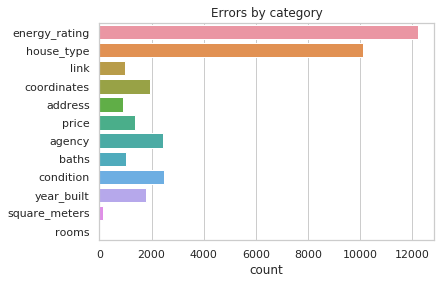

In [3]:
err_ax = sns.countplot(y='field', data=error_log)
err_ax.set_title('Errors by category')
err_ax.set_ylabel('')

## General information about the dataset

In [4]:
with open('data/immobiliare_data_raw.csv', 'r') as data_file:
    data = pd.read_csv(data_file)

print("(Rows, Columns) =", data.shape)

(Rows, Columns) = (41900, 13)


The data scraped from [immobiliare.it](https://www.immobiliare.it/) looks like this.

In [5]:
data.head(10)

,address,price,square_meters,rooms,baths,floor,type,year_built,condition,energy_rating,longitude,latitude,agency
0,"via Anneo Lucano 42, Roma",630000,144,4,3,4,Appartamento,1967,Ottimo/Ristrutturato,E,41.92,12.44,RE/MAX Abacus
1,"via dei Colli della Farnesina 72, Roma",1090000,198,5,3,4,Appartamento,1966,Ottimo / Ristrutturato,E,41.94,12.45,RE/MAX Abacus
2,"viale Pola, Roma",1200000,208,5,3,0,Appartamento,1956,Buono / Abitabile,F,41.64,12.44,KELLER WILLIAMS
3,NaN,690000,103,4,1,4,Attico,1935,Ottimo / Ristrutturato,F,44.93,7.54,Engel & Völkers Roma • Market Center
4,"via Vincenzo Troya, Roma",239000,90,3,1,0,Appartamento,1960,Buono / Abitabile,G,41.94,12.42,Bovi RE
5,"via del Moro 23, Roma",370000,66,3,1,2,Appartamento,1500,Ottimo / Ristrutturato,G,41.89,12.47,Coldwell Banker Exclusive RE
6,"via Dobbiaco 10, Roma",179000,59,2,1,1,Appartamento,NaN,€ 50/mese,0,41.74,12.38,Colossea
7,"via Bersone, Roma",349000,218,4,3,-2,NaN,2007,Ottimo / Ristrutturato,F,41.73,12.37,Colossea
8,"via Ostiense 85, Roma",419000,93,3,3,1,Appartamento,1960,Ottimo/Ristrutturato,G,41.87,12.48,Bovi RE
9,"viale Parioli, Roma",1250000,150,4,2,3,Appartamento,1952,Da ristrutturare,G,41.93,12.48,Coldwell Banker Exclusive RE


In [6]:
data.describe()

,price,square_meters,rooms,baths,floor,longitude,latitude
count,"41,900.00","41,900.00","41,900.00","41,900.00","41,900.00","41,900.00","41,900.00"
mean,"63,991,840.06","6,396.85",4.62,4.82,9.45,41.08,11.78
std,"4,153,319,427.70","32,590.06",35.82,31.01,27.66,6.64,2.90
min,0.00,0.00,0.00,0.00,-2.00,-32.81,-117.65
25%,"175,000.00",70.00,2.00,1.00,-1.00,41.83,12.38
50%,"260,000.00",97.00,3.00,2.00,1.00,41.89,12.47
75%,"419,000.00",143.00,4.00,2.00,3.00,41.94,12.55
max,"418,000,540,000.00","310,120.00","2,500.00","3,288.00",100.00,51.93,121.44


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41900 entries, 0 to 41899
Data columns (total 13 columns):
address          38693 non-null object
price            41900 non-null int64
square_meters    41900 non-null int64
rooms            41900 non-null int64
baths            41900 non-null int64
floor            41900 non-null int64
type             31803 non-null object
year_built       41050 non-null object
condition        41800 non-null object
energy_rating    41900 non-null object
longitude        41900 non-null float64
latitude         41900 non-null float64
agency           39472 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 4.2+ MB


Now we'll start exploring the varibles and cleaning them, from right to left.

## Agency

There are 2416 listed agencies.


Text(0.5, 1.0, 'Agencies Counts')

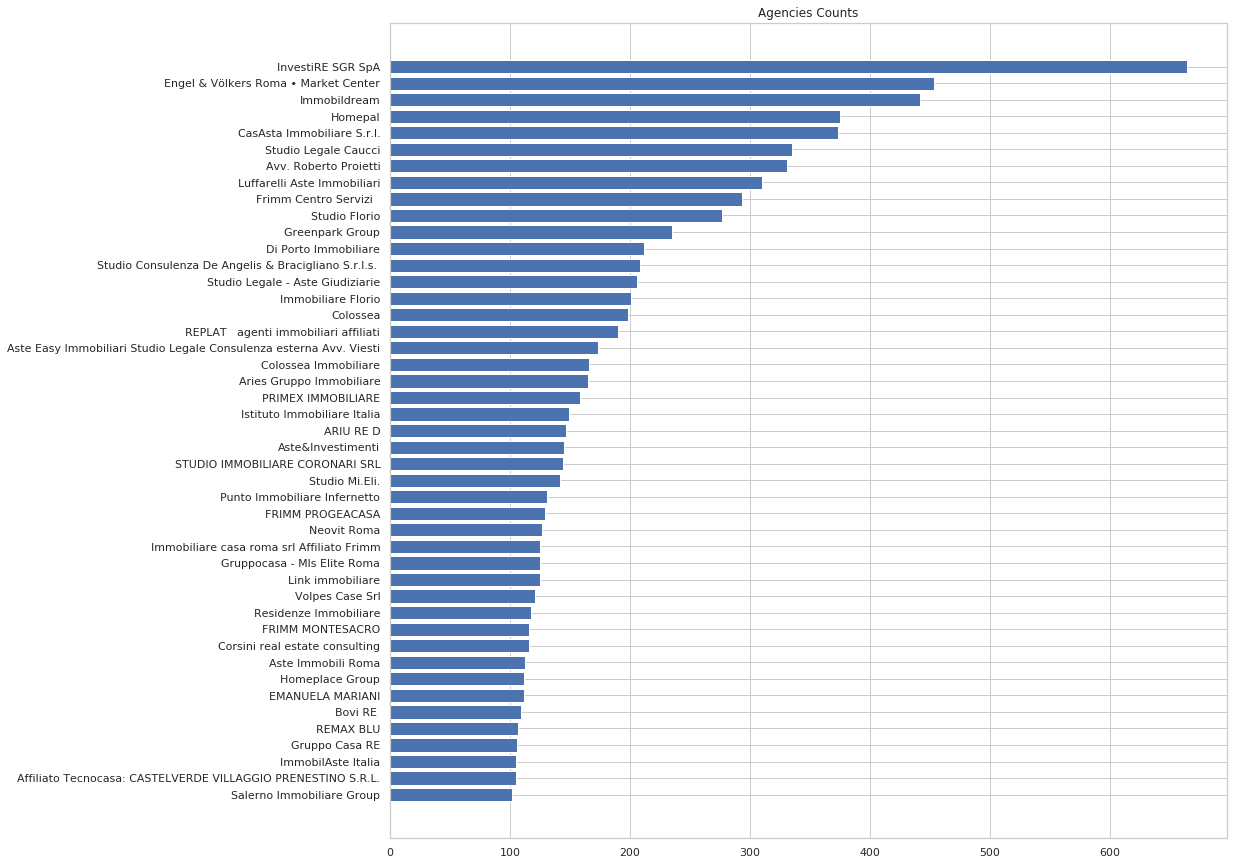

In [8]:
agencies = data.agency.value_counts().sort_values(ascending=True)
print("There are", len(agencies), "listed agencies.")
agencies = agencies[agencies > 100]

plt.figure(figsize=(15,15))
plt.barh(width=agencies, y=agencies.index)
plt.title('Agencies Counts')

## Coordinates

Here we restrict longitude and latitude coordinates to Italy only.

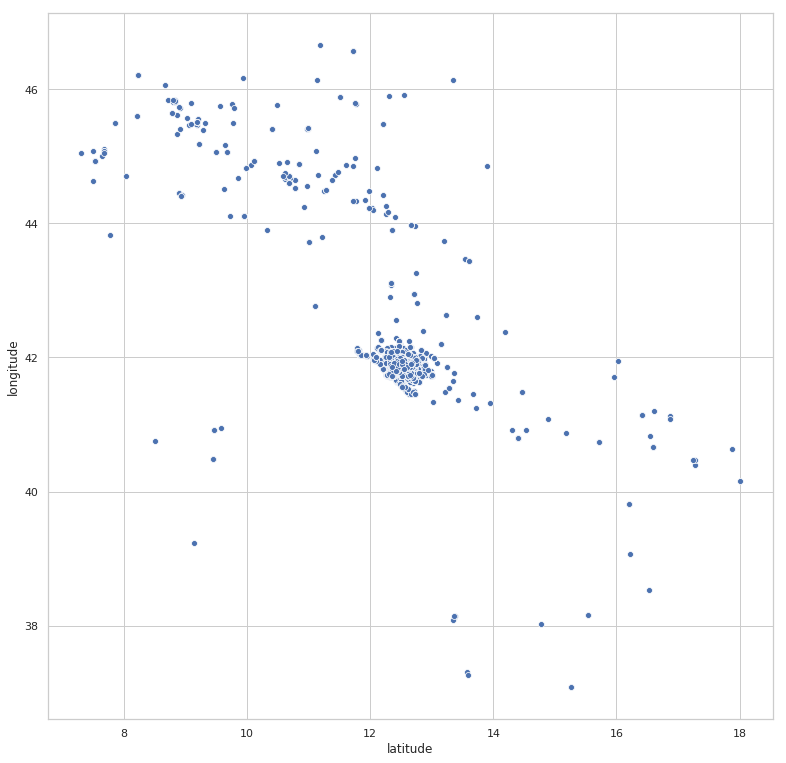

In [9]:
coord_data = data.loc[
    (data.latitude > 4) &
    (data.latitude < 25) &
    (data.longitude > 35) &
    (data.longitude < 48)
]

plt.figure(figsize=(13,13))
sns.scatterplot(
    x='latitude',
    y='longitude',
    data=coord_data
)

Quite a few houses we listed as belonging to the Rome area, even though they were not. I decided to restrict the analysis to Rome and its surrounding, were we have enought samples. 

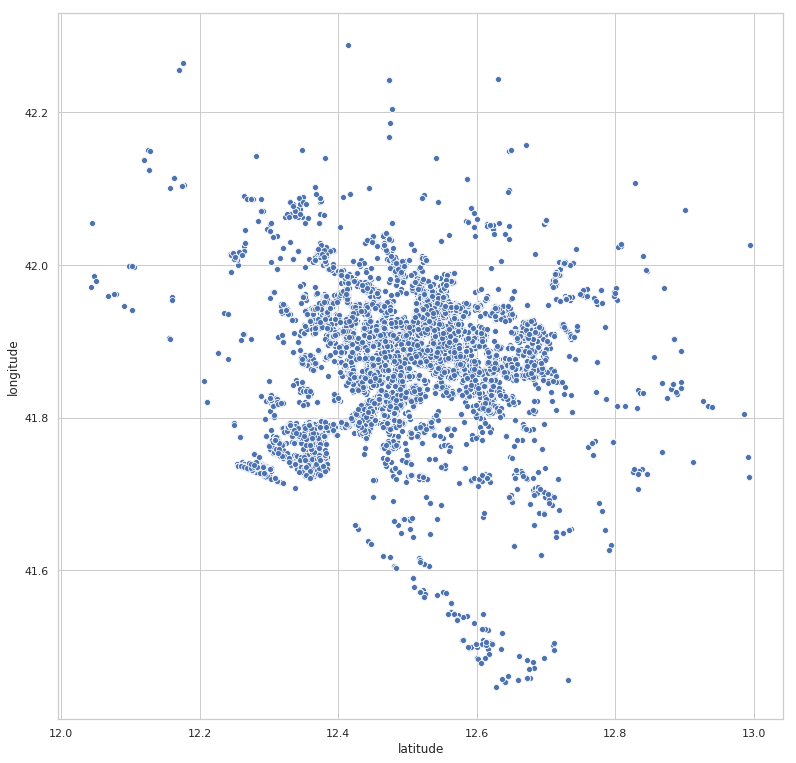

In [10]:
coord_data = data.loc[
    (data.latitude > 12) &
    (data.latitude < 13) &
    (data.longitude > 41) &
    (data.longitude < 42.3)
]

plt.figure(figsize=(13,13))
sns.scatterplot(
    x='latitude',
    y='longitude',
    data=coord_data
)

The rest is not excluded from the dataset right away. Rather I prefer to create an index of valid indices for each variable. To be valid an index must not be `NaN` and satisfy the criteria chosen for that particular variable. This is because an entry with wrong `type` might have a valid `price`, so we could include if we just wanted to do price analysis.
In this case we set valid `longitude` and `latitude` entries to be the ones in the Rome area.

In [11]:
valid_idx = {}
valid_idx['latitude'] = coord_data.index
valid_idx['longitude'] = coord_data.index

## Energy ratings

The European energy rating system assigns labels to each abitable unit in terms of Kilowatts necessary to heat one square meter for one hour. These labels are organized from A to G, further dividing A in A+, A, A1, A2, A3, A4.

![alt text](assets/classe-energetica.jpg)

Some entries are almost right, just having some trailing text after the energy rating letter.

In [12]:
# entries having some text trailing
energy_class_begin_regex = re.compile('[A-G][1-4\+]?,.+')
dirty_energy_data = data.energy_rating.loc[
    data.energy_rating.str.contains(energy_class_begin_regex)
].copy()
dirty_energy_data.head()

585    A1, edificio energia quasi zero
628    A2, edificio energia quasi zero
695    A2, edificio energia quasi zero
724    A1, edificio energia quasi zero
735    A2, edificio energia quasi zero
Name: energy_rating, dtype: object

It's easy to clean this data by simply cutting the text after the letters `A-G`. In some other entries the energy rating was indicated using the Kwh. We'll convert these ones using the table above. 

In [13]:
# cleaning data - part 1
take_energy = lambda s: s.split(',')[0]
data.energy_rating.iloc[dirty_energy_data.index] = dirty_energy_data.apply(take_energy)

# getting numerical energy formats
other_energy_formats = data.energy_rating.loc[data.energy_rating.str.contains('.*[1-9].*kWh/m²a')].copy()
print("There are", len(other_energy_formats), "entries of type:")
print(other_energy_formats.head(10))

There are 6652 entries of type:
247    ≥ 3,51 kWh/m²a
248    175,00 kWh/m²a
250    175,00 kWh/m²a
253    119,00 kWh/m²a
260    175,00 kWh/m²a
395    175,00 kWh/m²a
422    175,00 kWh/m²a
426    175,00 kWh/m²a
427    175,00 kWh/m²a
428    175,00 kWh/m²a
Name: energy_rating, dtype: object


/home/jonny/.local/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [14]:
energy_tr = {
    10: 'A+',
    30: 'A',
    50: 'B',
    70: 'C',
    90: 'D',
    120:'E',
    160: 'F',
    1000: 'G'
}

# cleaning data - part 2
get_number = lambda s: int(re.compile('[1-9]+').findall(s)[0])
get_class = lambda s: energy_tr[min([n for n in energy_tr.keys() if n >= get_number(s)])]

data.energy_rating.iloc[other_energy_formats.index] = other_energy_formats.apply(get_class)

Finally we're able to plot the energy rating distribution.

Text(0.5, 1.0, 'Energy Classes Counts')

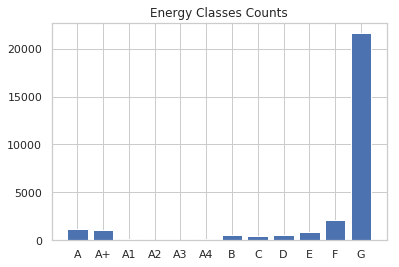

In [15]:
# entries exactly matching an energy rating
energy_class_regex = re.compile('[A-G][1-4\+]?$')
energy_data = data.energy_rating.loc[data.energy_rating.str.match(energy_class_regex)]

energy_hist = energy_data.value_counts()
energy_hist = energy_hist.sort_index()

plt.bar(x=energy_hist.index, height=energy_hist)
plt.title('Energy Classes Counts')

Text(0.5, 1.0, 'Energy ratings (As bundled together)')

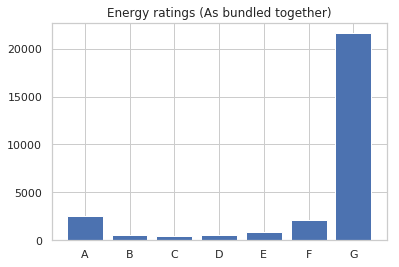

In [16]:
# bundling As together
energy_A = re.compile('A')
energy_hist['A'] = energy_hist.loc[energy_hist.index.str.match(energy_A)].sum()
energy_hist = energy_hist.drop(['A+','A1','A2', 'A3', 'A4'])

plt.bar(x=energy_hist.index, height=energy_hist)
plt.title('Energy ratings (As bundled together)')

Here are the percentages for the more quantitatively inclined.

In [17]:
# percentages
energy_hist / energy_data.shape[0] * 100

A    8.77
B    1.91
C    1.62
D    1.95
E    3.08
F    7.51
G   75.16
Name: energy_rating, dtype: float64

In [18]:
valid_idx['energy_rating'] = energy_data.index

## Condition and year built

From the scraper's logs two phenomena were evident (although you could deduce the same by just looking at the data).

- some entries have cadastral category 'A/2' and 'A/7' indeicated as house type, coresponding to 'Villa' and 'Villino' respectively
- in a lot of entries the house condition appeared in the `year_built` field

Here we take care of these two problems. First by finding the wrong entries...

In [19]:
types_list = [
    'Appartamento',
    'Attico',
    'Loft',
    'Open Space',
    'Mansarda',
    'Soffitta'
]

condition_list = [
    'Nuovo / In costruzione',
    'Nuovo/In costruzione'
    'Da ristrutturare',
    'Da ristrutturare',
    'Ottimo/Ristrutturato',
    'Ottimo / Ristrutturato',
    'Buono / Abitabile',
    'Buono/Abitabile'
]

wrong_apt_idxs = (
    (~data.type.isin(types_list)) &
    (data.condition.str.contains('Classe A/2'))
)
wrong_vil_idxs = (
    (~data.type.isin(types_list)) &
    (data.condition.str.contains('Classe A/7'))
)
wrong_year_idxs = (
    (~data.condition.isin(condition_list)) &
    (data.year_built.isin(condition_list))
)

wrong_apt_idxs = wrong_apt_idxs[wrong_apt_idxs].index
wrong_vil_idxs = wrong_vil_idxs[wrong_vil_idxs].index
wrong_year_idxs = wrong_year_idxs[wrong_year_idxs].index
        
print("Wrong Apartment entries:", len(wrong_apt_idxs))
print("Wrong house entries:", len(wrong_vil_idxs))
print("Wrong year entries:", len(wrong_year_idxs))

Wrong Apartment entries: 21
Wrong house entries: 51
Wrong year entries: 7938


...then by correcting mistakes.

In [20]:
data.loc[wrong_apt_idxs, 'type'] = 'Villa'
data.loc[wrong_apt_idxs,'condition'] = np.nan

data.loc[wrong_vil_idxs,'type'] = 'Villino'
data.loc[wrong_vil_idxs,'condition'] = np.nan

data.loc[wrong_year_idxs,'condition'] = data.loc[wrong_year_idxs,'year_built']
data.loc[wrong_year_idxs,'year_built'] = np.nan

data.loc[data.condition == 'Ottimo/Ristrutturato', 'condition'] = 'Ottimo / Ristrutturato'

We're now ready to see which house conditions are the most common.

Text(0.5, 0, '')

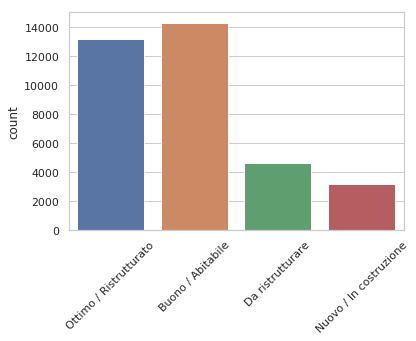

In [21]:
conditions = data.condition.loc[data.condition.isin(condition_list)]

condtion_ax = sns.countplot(conditions)
condtion_ax.set_xticklabels(condtion_ax.get_xticklabels(), rotation=45)
condtion_ax.set_xlabel('')

so far we discarded house conditions not in `condition_list`. What can we do for the other non-null ones?

Unfortunately not much beyond descarding it. It seems that apart from the `NaN` values, the condition field picked up some other DOM element from the HTML, irrelevant for our purposes.

In [22]:
invalid_condition_data = data.condition.loc[~data.index.isin(conditions.index)]
print("There are", len(invalid_condition_data), "entries with invalid conditions.")
print(invalid_condition_data.head(20))

valid_idx['condition'] = conditions.index

There are 6676 entries with invalid conditions.
6                          € 50/mese
10                               NaN
14                         € 50/mese
18                               NaN
27                               NaN
30     Classe A/7, rendita € 159.000
41                               NaN
64                         € 70/mese
71                               NaN
72                               NaN
75                               NaN
76                               NaN
85                               NaN
89                        € 300/anno
93                         € 70/mese
95     Classe A/7, rendita € 169.000
104                              NaN
106                              NaN
113                              NaN
118                              NaN
Name: condition, dtype: object


Now onto years. Here we see that the ones not conforming to the 4 digit year format are mostly `NaN`s.

In [23]:
year_re = re.compile('\d{4}$')
years = data.year_built[(~data.year_built.isnull()) & (data.year_built.str.match(year_re))].copy()

invalid_year_data = data[~data.index.isin(years.index)].year_built
print("There are", len(invalid_year_data), "entries with invalid years.")
print(invalid_year_data.head(20))

valid_idx['year_built'] = years.index

There are 13986 entries with invalid years.
6      NaN
10     NaN
14     NaN
18     NaN
27     NaN
30     NaN
41     NaN
64     NaN
71     NaN
72     NaN
75     NaN
76     NaN
85     NaN
89     NaN
93     NaN
95     NaN
104    NaN
106    NaN
113    NaN
118    NaN
Name: year_built, dtype: object


I chose to bundle the year values into decdes. We obtain a clear picture of which periods were most active in the real estate industry in Rome.

I also chose to not consider years previous to 1880. These few outliers don't share many characteristics of the other entries in the dataset, and would have made plots less clear.

Text(0.5, 0, 'Decade')

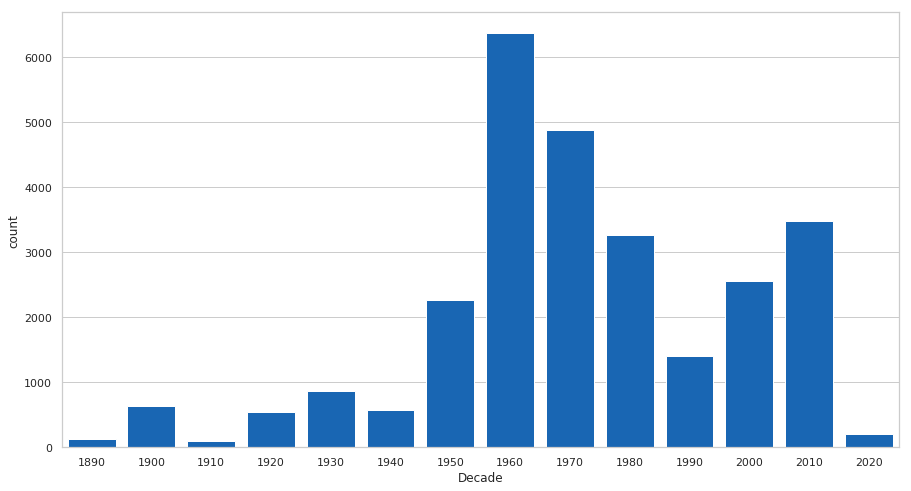

In [24]:
years = years.apply(lambda s: s[:3] + '0') #+ str((int(s[3]) // 5) * 5)) # 5 year chunks

plt.figure(figsize=(15,8))
year_ax = sns.countplot(x=years[years.astype(int) > 1880], color='#0066cc')
year_ax.set_xlabel('Decade')

## Type

House type are mosty 'Appartamento' (Flat) and 'Attico' (Attic). Any other type's frequency, 'Altro' (Other) in the first plot, pales in comparison to these two, and I chose to plot these ones separately.

The types 'Villa' and 'Villino' should be more common in my opinion. I inclined to say the the scraper incurred in a systematic error.

There are 10026 entries with NaN house type.


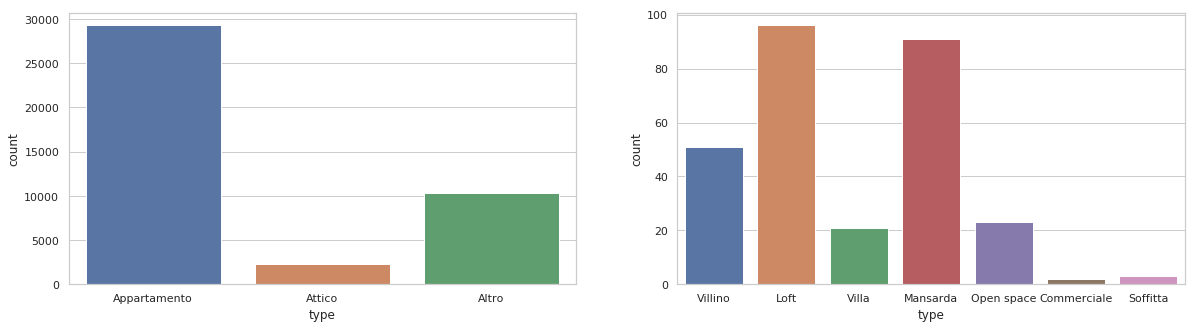

In [25]:
print("There are", len(data[data.type.isnull()]), "entries with NaN house type.")
data.loc[(~data.type.isnull()) & (data.type.str.contains('commerciale')), 'type'] = 'Commerciale'
valid_idx['type'] = data[~data.type.isnull()].index

types = data.type.copy()

fig, axes = plt.subplots(1,2, figsize=(20,5))

sns.countplot(types[~types.isin(['Appartamento', 'Attico'])], ax=axes[1])

types[~types.isin(['Appartamento', 'Attico'])] = 'Altro'
sns.countplot(types, ax=axes[0])

## Rooms and Bathrooms

Pretty simple. How many rooms/bathrooms does the house have?

First we must get rid of some irrealistic entries. How can a house be 39 square meters but have 14 bathrooms? Ask the scraper...

In [26]:
large_homes = data[(data.rooms > 5) & (data.rooms < 20)]
print(len(large_homes))
print(large_homes[['square_meters', 'rooms']])

12
       square_meters  rooms
682               39     14
701               44     15
8442              45     14
25605             50     14
38201              0     15
38251              0     13
39345              0      6
39684              0     17
39686              0      6
41830              1     14
41877              0     17
41888              0     13


In [27]:
large_homes = data[(data.baths > 5) & (data.baths < 20)]
print(len(large_homes))
print(large_homes[['square_meters', 'baths']])

valid_idx['rooms'] = data[data.rooms < 6].index
valid_idx['baths'] = data[data.baths < 6].index

0
Empty DataFrame
Columns: [square_meters, baths]
Index: []


Text(0.5, 0, '')

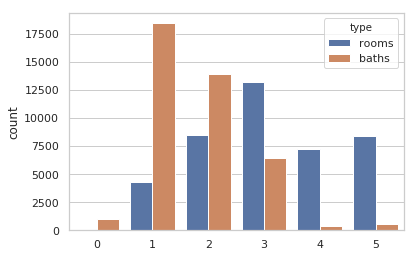

In [28]:
roombath_df = pd.concat([
    pd.DataFrame({
        'count': data.rooms[data.rooms < 6],
        'type': 'rooms'
    }),
    pd.DataFrame({
        'count': data.baths[data.baths < 6],
        'type': 'baths'
    })
])

roombath_ax = sns.countplot(x='count', hue='type', data=roombath_df)
roombath_ax.set_xlabel('')

## Floor

I gave the scraper the following codes for the floor number:

- -2: there was an exception
- -1: basement
- 0-9: regular floor
- 100: attic/top floor

There are 10059 invalid floor entries.


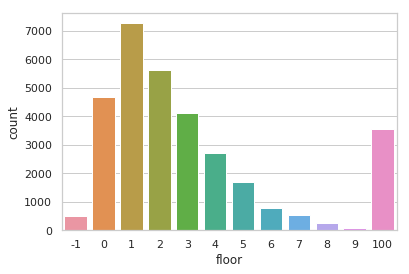

In [29]:
valid_idx['floor'] = data[data.floor > -2].index

floors = data.loc[valid_idx['floor'], 'floor']
sns.countplot(floors)

print("There are", len(data[~data.index.isin(valid_idx['floor'])]), "invalid floor entries.")

## Square meters

Again, there are some irrealistically low entries.

Some others are believable, but I chose not to consider houses inder 30 square meters since they do not represet the target we want to conduct our analysis on. The plot below show how there aren't even many entries of this kind.

There are 1574 houses measuring under 30 sqm
      square_meters   price
1205             27   87000
1796             26  158000
1845             25   89000
2763             29  105000
5259             20  119000
5276             23  109000
5418             22   80000
5867             28   85000
5929             20   89000
6213             18  135000


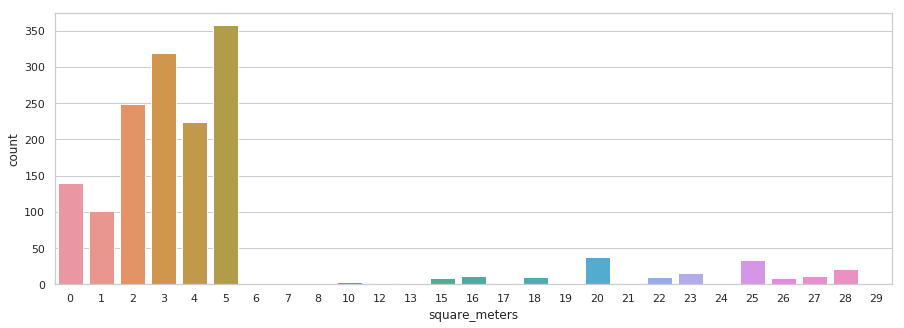

In [30]:
sqm_lower_bound = 30.

low_meters = data[data.square_meters < sqm_lower_bound]
print("There are", len(low_meters), "houses measuring under 30 sqm")

plt.figure(figsize=(15,5))
sns.countplot(low_meters.square_meters)

print(low_meters[low_meters.square_meters > 15.][['square_meters', 'price']].head(10))

Now onto plotting the normally sized houses. Again I had to clip the few outliers above 500 m².

As you can see the distribution is positively skewed. For this reason we apply the function `log(1+x)` the the variable, getting back a nice gaussian. (I know...the `1+` wasn't really necessary here since no value is close to 0) 

/home/jonny/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'log(square_meters)')

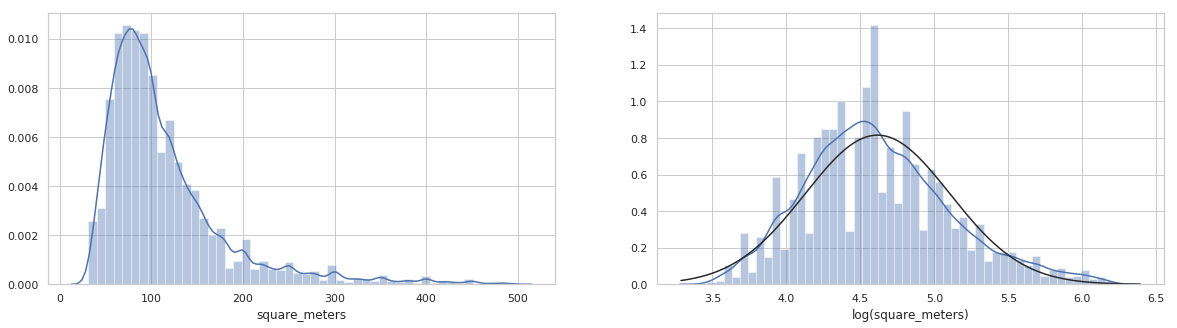

In [31]:
square_meters = data.square_meters[(data.square_meters < 5e+2) & (data.square_meters > sqm_lower_bound)]

fig, axes = plt.subplots(1,2, figsize=(20,5))
sns.distplot(square_meters.values, ax=axes[0])
axes[0].set_xlabel('square_meters')

log_square_meters = np.log1p(square_meters.values)

sns.distplot(log_square_meters, fit=norm, ax=axes[1])
axes[1].set_xlabel('log(square_meters)')

In [32]:
valid_idx['square_meters'] = data[(data.square_meters > sqm_lower_bound) & (~data.square_meters.isnull())].index

## Price

As with the `square_meters` variable, there are impossibly low as well as impossibly high prices.

In [33]:
price_lower_bound = 5e+4
prices = data['price']

print(f"There are {len(prices.loc[prices == 0])} entries with price=0€")
prices = prices[prices > price_lower_bound]

There are 461 entries with price=0€


In [34]:
fake_outliers = prices.loc[prices > 1e+8]
print(f"There are {len(fake_outliers)} houses with prices above 100 million €")
print("\n\nHere they are:")
fake_outliers

There are 11 houses with prices above 100 million €


Here they are:


682      168000524000
701      186000894000
953      169000179000
1120     289000323000
7365     139000252000
7939     161158236132
8204     340000390000
8442     283988798088
9027     418000540000
18390    280000780000
25605    231000693000
Name: price, dtype: int64

As you can see some of these prices look like two prices glued together. And that's exactly what they are. They are ranges privded by the agent in the form of "from X€ - up to Y€" On some of these the range was too wide to be a meaningful information, and I chose to cut these entries out. Some others I replaced with the average of the two, a middle point if you will.

In [35]:
bad_indices = [682, 701, 7365, 7939, 8442, 18390, 25605]
prices = prices.drop(index=bad_indices)

fake_outliers = fake_outliers.drop(index=bad_indices)

fake_outliers.loc[953] = (169000 + 179000) / 2
fake_outliers.loc[1120] = (289000 + 323000) / 2
fake_outliers.loc[8204] = (340000 + 390000) / 2
fake_outliers.loc[9027] = (418000 + 540000) / 2

prices.loc[fake_outliers.index] = fake_outliers
data.loc[fake_outliers.index].price = fake_outliers

Since we're not trying to explore the luxurious house market, but rather the standard one for laypeople, we'll drop houses priced at more than 2 million € for this analysis.

As for the square meters, the distribution is positively skewed, but applying `log(1+x)` gets us an even nicer gaussian.

Text(0.5, 0, 'log(price)')

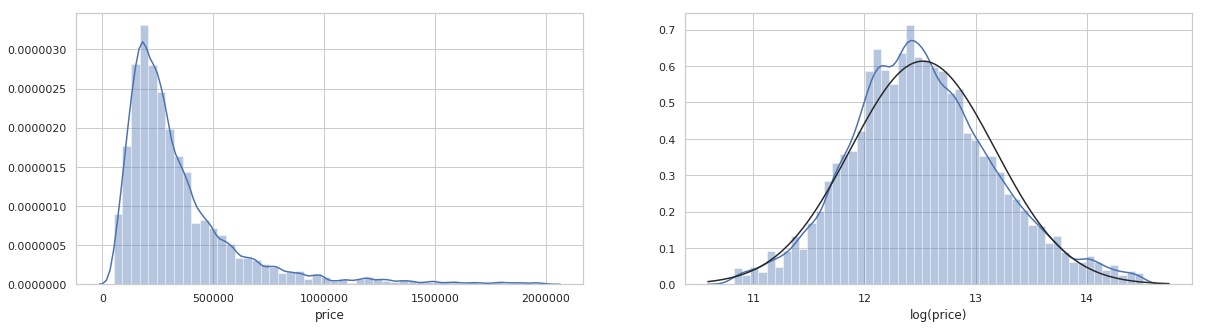

In [36]:
prices = prices.loc[prices < 2e+6]

fig, axes = plt.subplots(1,2, figsize=(20,5))
sns.distplot(prices.values, ax=axes[0])
axes[0].set_xlabel('price')

log_prices = np.log1p(prices.values)
sns.distplot(log_prices, fit=norm, ax=axes[1])
axes[1].set_xlabel('log(price)')

We privided basic statistics for every quantitative variable at the start of the notebook. Here I do it again for the price range considered (15k - 5m €).

In [37]:
print("Price Mean: {:.2f}".format(prices.mean()))
print("Price Median: {:.2f}".format(prices.median()))
print("Price Std: {:.2f}".format(prices.std()))

Price Mean: 344702.84
Price Median: 265000.00
Price Std: 271154.70


In [38]:
valid_idx['price'] = data[(data.price > price_lower_bound) & (~data.price.isnull())].index

That was the last variable. As we took care of logging the acceptable indices for each one of them, We'll now set the non-accepatble values to `NaN` in the dataset itself.

In [39]:
for colname in data.columns:
    try: 
        good_indices = valid_idx[colname]
    except Exception as exc:
        print(type(exc), exc)
        good_indices = data.index
    data.loc[~data.index.isin(good_indices), colname] = np.nan

<class 'KeyError'> 'address'
<class 'KeyError'> 'agency'


# Dependencies between variables

The relationship between price and quare meters is best analyzed taking their logarithms. They exibit a clear linear dependence up to a point.

Of course very large properties don't folow this patter anymore. This is to be expected, since the houses in question are probably located in rural areas, were prices are much lower.

1699


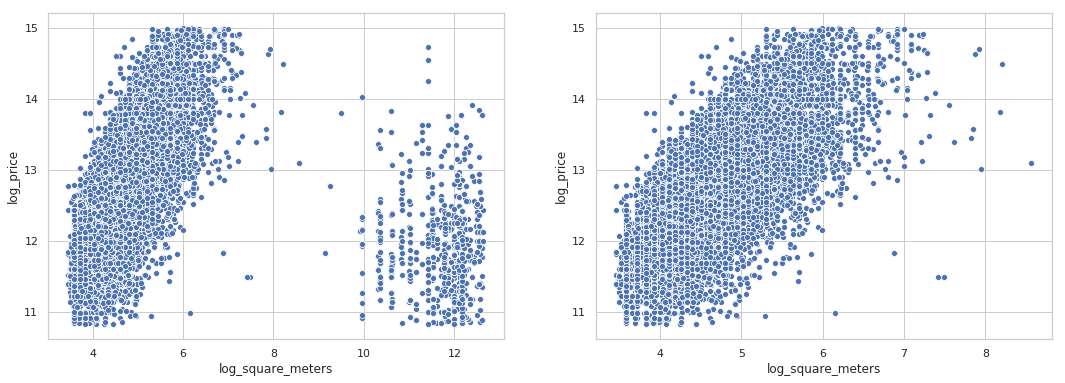

In [40]:
df = copy(data)

df['log_price'] = np.log1p(df.price)
df['log_square_meters'] = np.log1p(df.square_meters)
#df.drop(columns=['price', 'square_meters'])

fig, axes = plt.subplots(1,2, figsize=(18,6))

df = df[df.log_price < 15.]
sns.scatterplot(x='log_square_meters', y='log_price', data=df, ax=axes[0])

print(len(df[df.log_square_meters > 9.]))

df = df[df.log_square_meters < 9.]
sns.scatterplot(x='log_square_meters', y='log_price', data=df, ax=axes[1])

Here I grouped boxplots for the categorical variables which showed a relevant influence on the `price` variable.

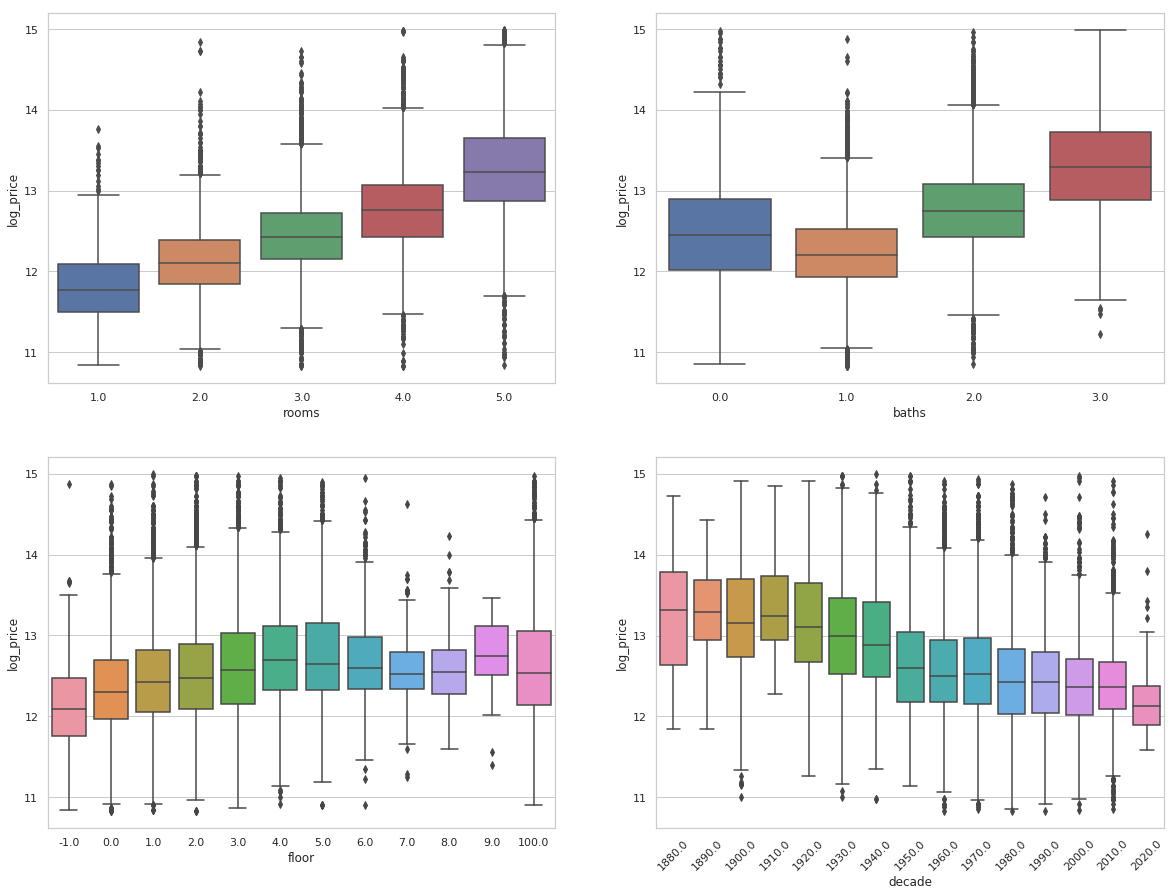

In [41]:
import math
get_decade = lambda y: (y // 10) * 10 if not math.isnan(y) and y > 1880 else np.nan
df.loc[~df.year_built.isnull(), 'decade'] = df[~df.year_built.isnull()].year_built.astype(int).apply(get_decade)

fig, axes = plt.subplots(2,2, figsize=(20,15))
sns.boxplot(x='rooms', y='log_price', data=df, ax=axes[0,0])
sns.boxplot(x='baths', y='log_price', data=df, ax=axes[0,1])

sns.boxplot(x='floor', y='log_price', data=df, ax=axes[1,0])
sns.boxplot(x='decade', y='log_price', data=df, ax=axes[1,1])
_ = axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=45)

Text(0.5, 0, '')

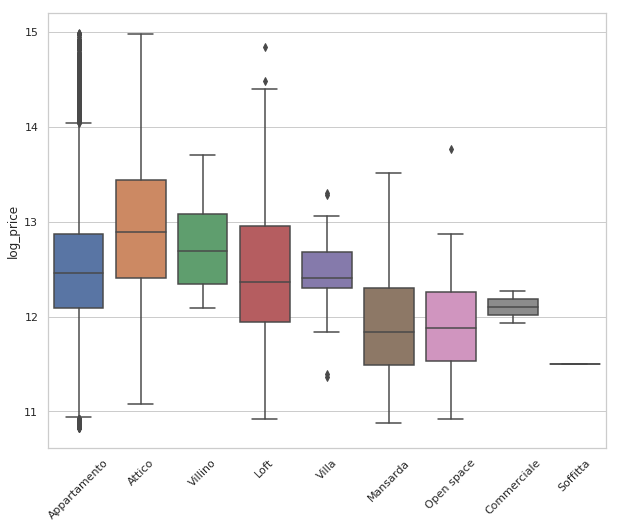

In [42]:
plt.figure(figsize=(10,8))
ax = sns.boxplot(x='type', y='log_price', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('')

And here are the not so relevant ones.

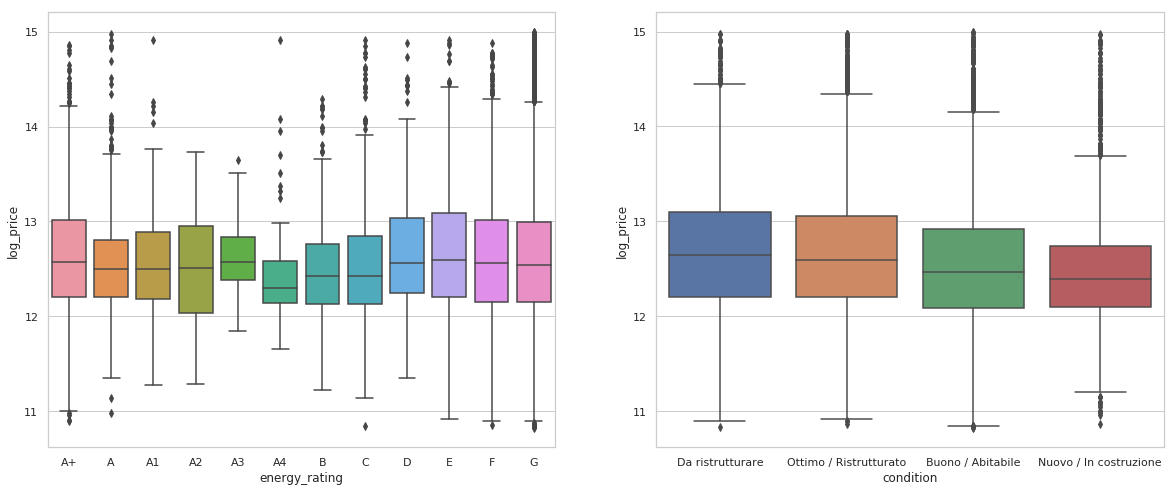

In [43]:
condition_order = [
    'Da ristrutturare',
    'Ottimo / Ristrutturato',
    'Buono / Abitabile',
    'Nuovo / In costruzione'
]
energy_rating_order = ['A+', 'A', 'A1', 'A2','A3','A4', 'B', 'C', 'D', 'E', 'F', 'G']

fig, axes = plt.subplots(1,2, figsize=(20,8))
sns.boxplot(x='condition', y='log_price', data=df, ax=axes[1], order=condition_order)
sns.boxplot(x='energy_rating', y='log_price', data=df, ax=axes[0], order=energy_rating_order)

Finally a global, but not so precise, heatmap showing the correlation matrix of all variables considered.

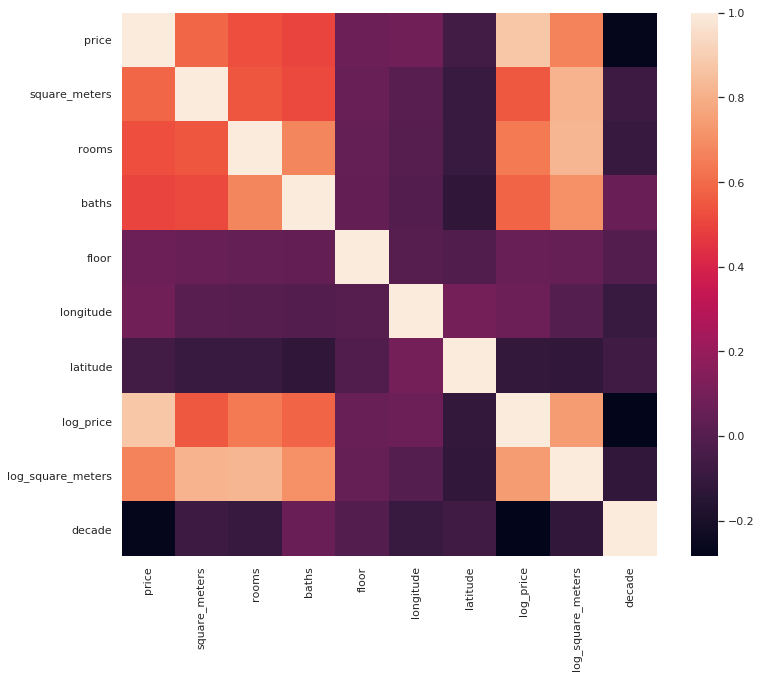

In [44]:
corrmat = df.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corrmat)

In [45]:
from sklearn.ensemble import RandomForestClassifier

rf_idx = df.index
for idx in valid_idx.values():
    rf_idx = rf_idx.intersection(idx)
print(len(rf_idx))

dfr = df.loc[rf_idx]
dfr = dfr[dfr.year_built.astype(int) > 1880]
X = dfr.drop(['log_price', 'price', 'square_meters', 'address', 'agency', 'energy_rating', 'floor'], axis=1)
y = dfr.log_price

X = pd.get_dummies(X)
print(X[X.isnull().any(axis=1)].head(50))

rfc = RandomForestClassifier(max_depth=5)
rfc.fit(X, y)

y_ticks = np.arange(0, len(X.columns))
plt.hbar(y_ticks, rfc.feature_importance_)

18165
Empty DataFrame
Columns: [rooms, baths, longitude, latitude, log_square_meters, decade, type_Appartamento, type_Attico, type_Loft, type_Mansarda, type_Open space, year_built_1881, year_built_1885, year_built_1886, year_built_1887, year_built_1888, year_built_1889, year_built_1890, year_built_1891, year_built_1892, year_built_1895, year_built_1896, year_built_1898, year_built_1900, year_built_1902, year_built_1903, year_built_1905, year_built_1908, year_built_1909, year_built_1910, year_built_1911, year_built_1912, year_built_1914, year_built_1915, year_built_1918, year_built_1919, year_built_1920, year_built_1921, year_built_1922, year_built_1923, year_built_1924, year_built_1925, year_built_1926, year_built_1927, year_built_1928, year_built_1929, year_built_1930, year_built_1931, year_built_1932, year_built_1933, year_built_1934, year_built_1935, year_built_1936, year_built_1937, year_built_1938, year_built_1939, year_built_1940, year_built_1941, year_built_1942, year_built_1944

/home/jonny/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: Unknown label type: 'continuous'

# Price VS Coordinates

In [46]:
import folium
from folium.plugins import HeatMap


max_amount = float(df['log_price'].max())

fig = folium.Figure(width=800, height=700)
hmap = folium.Map(location=[41.856433, 12.442435], zoom_start=11,).add_to(fig)# width=500, height=500)

hm_wide = HeatMap(
    list(zip(dfr.longitude.values, dfr.latitude.values, dfr.log_price.values)),
    min_opacity=0.,
    max_val=12,#dfr.log_price.max(),
    radius=3, blur=5, 
    max_zoom=1, 
).add_to(hmap)
hmap